*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA4703-1 Control Óptimo: Teoría y Laboratorio**  
**Profesor:** Héctor Ramírez  
**Auxiliares:** Javier Madariaga y Pablo Araya

**Nro. de grupo:** 20  
**Integrantes:** Tomás Banduc, Felipe Urrutia

# Laboratorio 2: 
## Controlabilidad, observabilidad, estabilidad y detectabilidad

El objetivo del presente laboratorio es estudiar la controlabilidad, observabilidad, estabilidad
y detectabilidad de un sistema lineal controlado. Para esto, se pide verificar los respectivos criterios de
manera directa y usando el paquete $\texttt{control}$ de Python. También se estudian conceptos relacionados
como la matriz Gramiana y la forma canónica de Brunovski.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import control
import pandas as pd

<h2><center>Parte A</center></h2>

## Ejercicio 1

Un barco carguero debe llevar su cargamento hasta el puerto de Guangzhou, ubicado en el sur de China, atravesando el Océano Pacífico.

El movimiento descrito por dicho barco se basa de las siguientes suposiciones:

- El par $(x(t), y(t))$ es el vector $(abscisa, ordenada)$ que indica la posición del barco en el océano en un tiempo $t$.
- El barco se mueve con rapidez constante igual a V.
- El mar posee corrientes marinas que dependen solo de la posición $(x(t), y(t))$ del barco, y que influyen en su movimiento actuando como una fuerza externa, denotada por $\vec{G}(x, y) = (G1(x, y), G2(x, y))^T$.
- La masa del barco disminuye a medida que este consume combustible. Por simplicidad, se supone que esta disminución de masa es conocida, y depende solo del tiempo $t$, obteniendo así una función denotada $m(t)$.
- Los efectos del roce o viscosidad son despreciables.
- La posición del puerto Guangzhou se encuentra en el origen.

Dadas las suposiciones anteriores y, en virtud de la Segunda Ley de Newton, se tiene que el movimiento del barco satisface al relación:

$$ \begin{pmatrix}
G_1(x(t),y(t))\\
G_2(x(t),y(t)) 
\end{pmatrix} 
=
\dfrac{d (m(t)\vec{V}(t))}{dt}
=
\dot{m}(t)\begin{pmatrix}
\dot{x}(t) \\
\dot{y}(t)
\end{pmatrix}
+m(t)
\begin{pmatrix} \ddot{x}(t) \\
\ddot{y}(t) 
\end{pmatrix}$$

Despejando, esto equivale a $
\begin{pmatrix}
\ddot{x}(t) \\
\ddot{y}(t) 
\end{pmatrix}
=  
\dfrac{1}{m(t)}
\begin{pmatrix}
G_1(x(t),y(t)) \\
G_2(x(t),y(t))
\end{pmatrix}
-
\dfrac{\dot{m}(t)}{m(t)}
\begin{pmatrix}
\dot{x}(t) \\
\dot{y}(t) 
\end{pmatrix}$.

Además, $
\vec{V}(t)
=
\begin{pmatrix}
\dot{x}(t) \\
\dot{y}(t) 
\end{pmatrix}$. 

Luego, el sistema que describe la trayectoria de la nave viene dado por:

$$\begin{align*}
\dot{
\begin{pmatrix}
x(t) \\ 
\dot{x}(t) \\ 
y(t) \\ 
\dot{y}(t) 
\end{pmatrix}
}
&= 
\begin{pmatrix}
\dot{x}(t) \\ 
-\frac{\dot{m}(t)}{m(t)}\dot{x}(t) \\
\dot{y}(t)\\ 
-\frac{\dot{m}(t)}{m(t)}\dot{y}(t)
\end{pmatrix}
+
\begin{pmatrix}
0 \\ 
\frac{G_1(x(t),y(t))}{m(t)} \\
0\\ 
\frac{G_1(x(t),y(t))}{m(t)}
\end{pmatrix}\\
&=
\begin{pmatrix}
0 & 1 & 0 & 0 \\ 
0 & -\frac{\dot{m}(t)}{m(t)} & 0 & 0 \\
0 & 0 & 0 & 1\\ 
0 & 0 & 0 & -\frac{\dot{m}(t)}{m(t)}\dot{y}(t)
\end{pmatrix}
\begin{pmatrix}
x(t) \\ 
\dot{x}(t) \\
y(t) \\ 
\dot{y}(t)
\end{pmatrix}
+
\begin{pmatrix}
0 \\ 
\frac{G_1(x(t),y(t))}{m(t)} \\
0\\ 
\frac{G_1(x(t),y(t))}{m(t)}
\end{pmatrix}
\end{align*}
$$ 

Tomando $
\vec{X}(t)
:=
\begin{pmatrix}
x_1(t) \\
x_2(t) \\
x_3(t) \\
x_4(t) \\
\end{pmatrix}
:=
\begin{pmatrix}
x(t) \\
\dot{x}(t) \\
y(t) \\
\dot{y}(t) \\
\end{pmatrix}$, 
$
A(t)
:=
\begin{pmatrix}
0 & 1 & 0 & 0 \\ 
0 & -\frac{\dot{m}(t)}{m(t)} & 0 & 0 \\
0 & 0 & 0 & 1\\ 
0 & 0 & 0 & -\frac{\dot{m}(t)}{m(t)}\dot{y}(t)
\end{pmatrix}$ y
$
\tilde{G}(\vec{X}(t))
:=
\begin{pmatrix}
0 \\ 
\frac{G_1(x_1(t),x_3(t))}{m(t)} \\
0\\ 
\frac{G_1(x_1(t),x_3(t))}{m(t)}
\end{pmatrix}
$,

se obtiene un sistema no-lineal y no-autónomo:

$$ \dot{\vec{X}}(t)=A(t)\vec{X}(t)+\tilde{G}(\vec{X}(t))$$

## Ejercicio 2

Supongamos ahora que las corrientes marinas vienen dadas por una función $\vec{G}$ lineal.
En este caso, estas corrientes vienen representadas por el siguiente sistema lineal de EDO:

$$(S)
\left\{
\begin{array}
[c]{cl}
\dot{x}(t)=ax(t)+by(t) \\
\dot{y}(t)=cx(t)+dy(t)
\end{array}
\right.
$$ 

, donde $a,b,c,d$ son constantes. A continuación, se muestran los diagramas de fase para las soluciones de $(S)$ según distintas asignaciones de parámetros, que se obtienen utilizando la applet $\texttt{pyplane}$.

In [2]:
# import run_pyplane

<img src="figures/e2_fig1.png" />

**Figura 1**: Diagrama de fase para $(S)$, con $a=b=c=d=1$.

<img src="figures/e2_fig2.png" />

**Figura 2**: Diagrama de fase para $(S)$, con $a=b=d=1, c=-1$.

<img src="figures/e2_fig3.png" />

**Figura 3**: Diagrama de fase para $(S)$, con $a=1,d=2,b=c=-1$.

<img src="figures/e2_fig4.png" />

**Figura 4**: Diagrama de fase para $(S)$, con $a=d=1,b=-1,c=10$.

<img src="figures/e2_fig5.png" />

**Figura 5**: Diagrama de fase para $(S)$, con $a=0, b=d=1, c=10$.

Derivando con respecto al tiempo, se deduce de $(S)$ la relación $$
\dot{\vec{X}}(t)=
\begin{pmatrix}
\dot{x}(t) \\
\ddot{x}(t) \\
\dot{y}(t) \\
\ddot{y}(t)\\
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 & 0 & 0 \\ 
0 & a & 0 & b\\ 
0 & 0 & 0 & 1\\ 
0 & c & 0 & d
\end{pmatrix}\vec{X}(t)=\tilde{A}\vec{X}(t)$$

Para maniobrar el barco se introduce un motor que produce cambios de aceleración horizontales
y verticales, dados por $u$ y $v$, respectivamente. 

Haciendo uso del modelo de la parte anterior, e intorduciendo la acelaración dada por $(u(t),v(t))$, queda la dinámica:

$$
\dot{\vec{X}}(t)
=
\begin{pmatrix}
0 & 1 & 0 & 0 \\ 
0 & a & 0 & b\\ 
0 & 0 & 0 & 1\\ 
0 & c & 0 & d
\end{pmatrix}
\vec{X}(t)
+
\begin{pmatrix} 0 & 0 \\ 1 & 0 \\ 0 & 0 \\ 0 & 1\end{pmatrix}
\begin{pmatrix} u(t) \\ v(t) \end{pmatrix}
=\tilde{A}\vec{X}(t)+B\vec{U}(t)
$$

<h2><center>Parte B</center></h2>

En la presente sección, se supone que no hay cambios en la masa, es decir, $m(t) = m > 0$ para todo
$t \geq 0$. Además, consideramos las siguientes configuraciones de parámetros:

- $a = −1, b = −2, c = 4, d = −5$
- $a = −1, b = 0, c = 4, d = −1$

## Ejercicio 3

En los siguientes bloques de código, se simulan y grafican las trayectorias del sistema para diferentes controles (constante, sinusoidal, feedback y bang-bang) y distintas condiciones iniciales, haciendo uso de $\texttt{solve_ivp}$.

In [2]:
# Definimos el sistema asociado al problema de control optimo

def control_system(t, x, A, B, u):
    dx = A @ x + B @ u(x, t)
    return dx

In [199]:
# Control constante

def u0(x,t):
    return np.zeros(2)

def u1(x, t): 
    
    return np.array([-2, 1])

# Control sinusoidal

def u2(x, t): 
    
    return np.array([np.sin(2*t), np.cos(t)])

# Control bang-bang

def u3(x, t): 
    
    if t < 1:
        return np.array([-1, -1])
    elif 1<= t < 2:
        return np.array([1, -1])
    elif 2 <= t < 5:
        return np.array([-1, 1])
    elif 5 <= t < 7:
        return np.array([-1, 1])
    elif 7 <= t < 10:
        return np.array([1, 1])
    else:
        return np.array([1, -1])

# Control feedback

def u4(x, t): 
    
    Z = np.array([[0, 1, -1, 1],
                  [1, -1, 1, 0],])
    return Z @ x

In [94]:
# Definimos los datos del problema

def datos(a, b, c, d):
    
    A = np.array([[0, 1, 0, 0], 
                  [0, a, 0, b],
                  [0, 0, 0, 1],
                  [0, c, 0, d]])
    
    B = np.array([[0, 0],
                  [1, 0],
                  [0, 0],
                  [0, 1]])
    
    return A, B

# Matrices a utilizar

A1, B1 = datos(a=-1, b=-2, c=4, d=-5)
A2, B2 = datos(a=-1, b=0, c=4, d=-1)

In [59]:
def solve_u(A, B, u, x_0=np.array([0,0,1,1]),t_span=(0.0,10.0)):
    
    sol_ivp = solve_ivp(control_system, t_span, x_0, args=[A, B, u], dense_output=True)
    
    return sol_ivp

In [166]:
def plot_ej_3(A, B, u, X_0, t_span, title):
    
    SOL_IVP = [solve_u(A, B, u, x_0, t_span) for x_0 in X_0]
    T = np.arange(t_span[0], t_span[1], 0.01)
    
    fig, ax = plt.subplots(1,1, figsize=(15,6),sharey=True, sharex=True) 
    
    ax.set_title(title)
    ax.set_xlabel(r'$x$')  
    ax.set_ylabel(r'$y$')
    ax.grid(zorder=-1)
    
    for i in range(3):
        x_0=X_0[i]
        X_, Y_ = SOL_IVP[i].sol(T)[0], SOL_IVP[i].sol(T)[2]
        ax.plot(X_,Y_, label=r'$(x(t),y(t)); u='+str(u.__name__)+'; X_0='+str((x_0[0],x_0[1],x_0[2],x_0[3]))+'$', linewidth=1.5)
        ax.scatter([x_0[0]],[x_0[2]],zorder=2,color='black',marker='*')
    
    ax.legend()
    return SOL_IVP

In [140]:
X_0 = [np.array([0,0,0,10]),np.array([0,1,0,1]),np.array([0,10,0,-5])]
t_span=(0,10)
plt.style.use("seaborn")

CPU times: total: 46.9 ms
Wall time: 44 ms


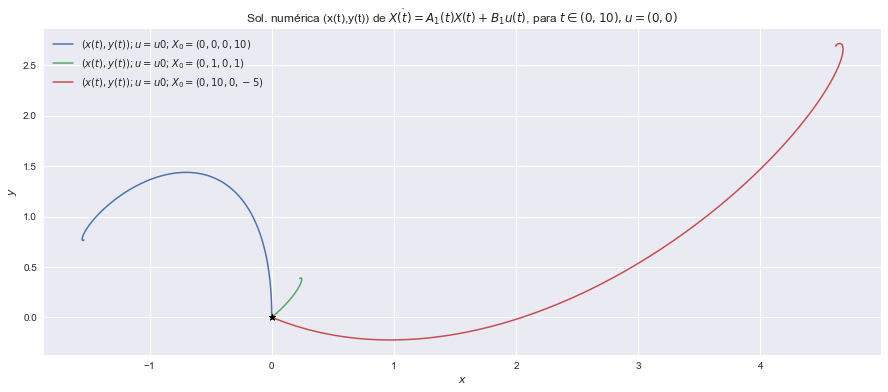

In [167]:
%%time
# constante (0,0)
SOL_IVP_1_U1=plot_ej_3(A1, B1, u0, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u =(0,0)$')

**Figura 6**: Trayectorias para sistema con $(a,b,c,d)=(-1,-2,4,-5)$, $u$ nulo, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 62.5 ms
Wall time: 42 ms


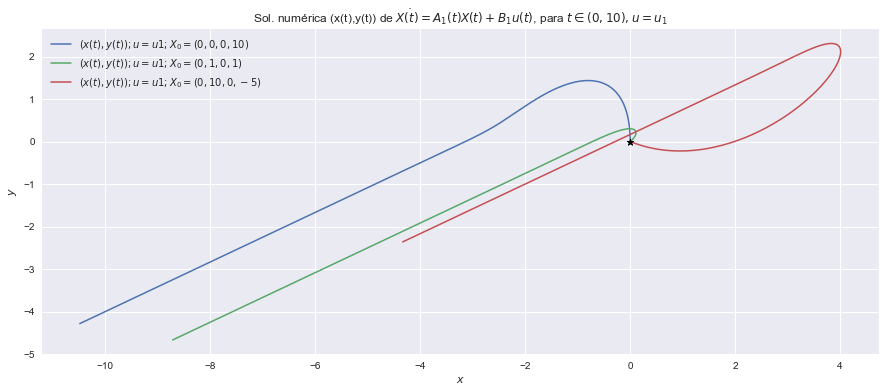

In [53]:
%%time
# constante
SOL_IVP_1_U1=plot_ej_3(A1, B1, u1, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u =u_1$')

**Figura 7**: Trayectorias para sistema con $(a,b,c,d)=(-1,-2,4,-5)$, $u$ constante, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 188 ms
Wall time: 179 ms


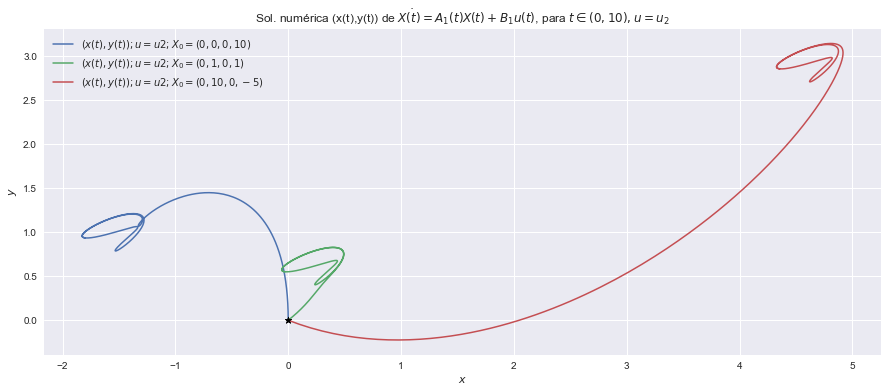

In [198]:
%%time 
# sinusoidales
SOL_IVP_1_U2=plot_ej_3(A1, B1, u2, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u=u_2$')

**Figura 8**: Trayectorias para sistema con $(a,b,c,d)=(-1,-2,4,-5)$, $u$ sinusoidal, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 78.1 ms
Wall time: 69 ms


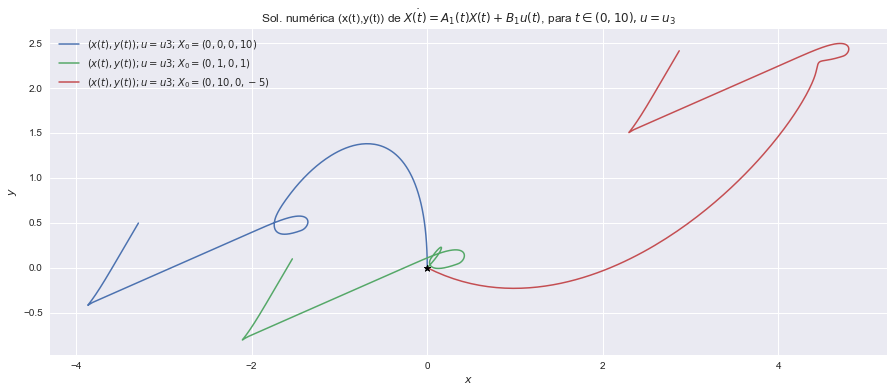

In [201]:
%%time 
# bang-bang
SOL_IVP_1_U3=plot_ej_3(A1, B1, u3, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u=u_3$')

**Figura 9**: Trayectorias para sistema con $(a,b,c,d)=(-1,-2,4,-5)$, $u$ *bang-bang*, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 46.9 ms
Wall time: 48 ms


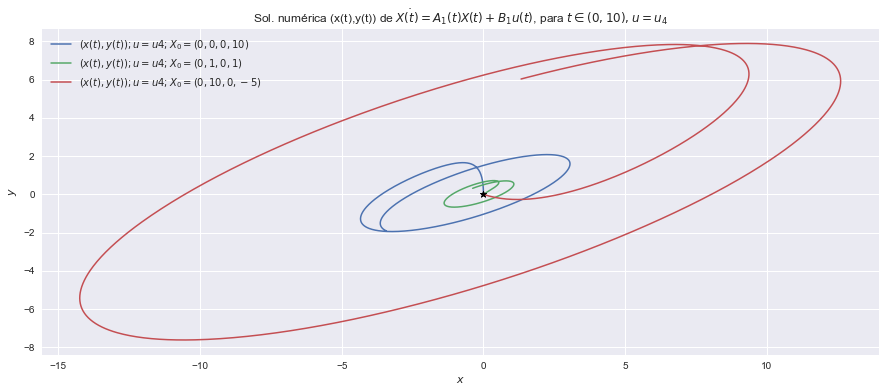

In [84]:
%%time 
# feedback
SOL_IVP_1_U4=plot_ej_3(A1, B1, u4, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u=u_4$')

**Figura 10**: Trayectorias para sistema con $u$ *feedback*, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

Para los gráficos anteriores, se observa que, para un control fijo y distintas condiciones iniciales, las trayectorias descritas son semejantes salvo por la escala en que se realiza el movimiento. Amplificando la rapidez inicial en ciertas direcciones y utilizando un determinado control, la velocidad puede contrarrestar los efectos del campo vectorial al que se somete el barco inicialmente y contribuir a su desplazamiento en una dirección distinta. Por ejemplo, cuando se tiene un control constante $(-2,1)$, la tendencia en la trayectoria del móvil es de alejamiento indefinido con respecto del origen en el tercer cuadrante del plano, mientras que, cuando se tiene un $u$ sinusoidal, la trayectoria descrita asimila a la de un sistema libre de control ($u\equiv(0,0)$), salvo en tiempos avanzados, donde el movimiento se vuelve periódico y acotado (en efecto, para tiempos $t>10$, la nave reincide en posiciones o estados previamente alcanzados); para movimiento sujeto a control *bang-bang*, a partir de cierto instante el móvil se queda en el primer cuadrante y también se aleja del origen (es  esperable que, para mayores tiempos, la nave se aleje indefinidamente de $(0,0)$ en dicha dirección). Finalmente, cuando se tiene *feedback*, el movimiento se vuelve elíptico y progresivamente más amplio.

CPU times: total: 62.5 ms
Wall time: 41 ms


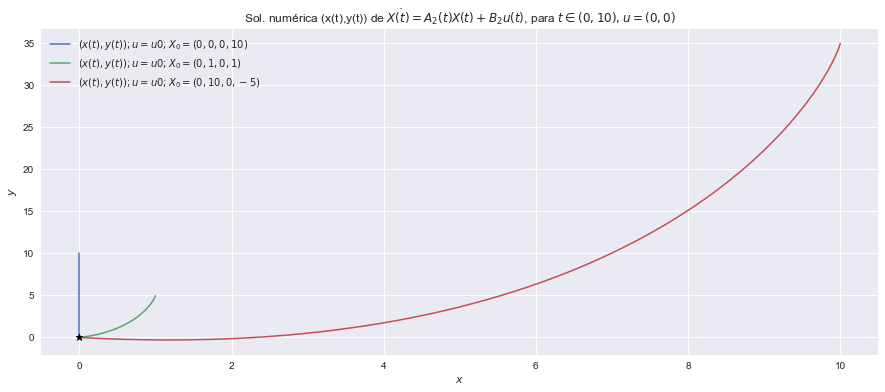

In [180]:
%%time
# constante nulo
SOL_IVP_2_U0=plot_ej_3(A2, B2, u0, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u =(0,0)$')

**Figura 11**: Trayectorias para sistema con $(a,b,c,d)=(-1,0,4,-1)$, $u$ nulo, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 31.2 ms
Wall time: 36 ms


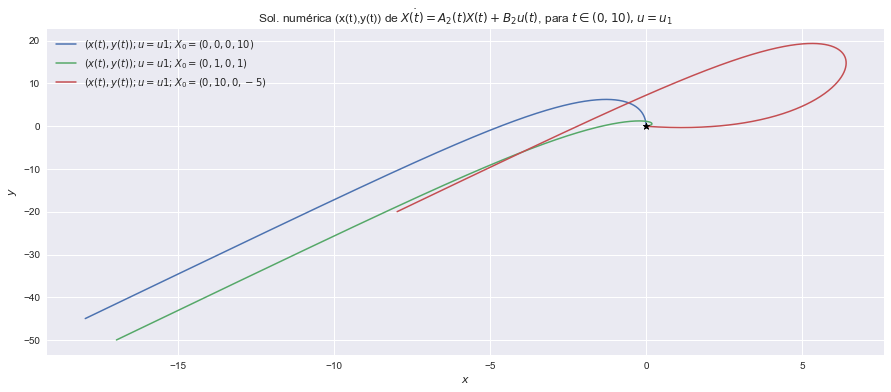

In [193]:
%%time
# constante
SOL_IVP_2_U1=plot_ej_3(A2, B2, u1, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u =u_1$')

**Figura 12**: Trayectorias para sistema con $(a,b,c,d)=(-1,0,4,-1)$, $u$ constante, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 46.9 ms
Wall time: 55 ms


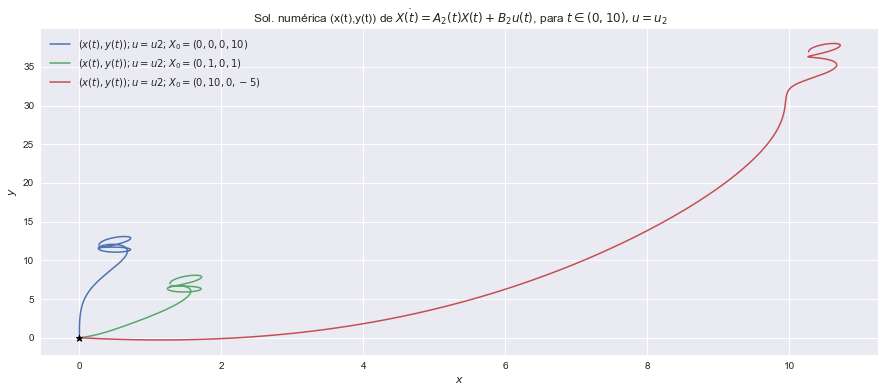

In [196]:
%%time
# sinusoidal
SOL_IVP_2_U2=plot_ej_3(A2, B2, u2, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u =u_2$')

**Figura 13**: Trayectorias para sistema con $(a,b,c,d)=(-1,0,4,-1)$, $u$ sinusoidal, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 46.9 ms
Wall time: 46 ms


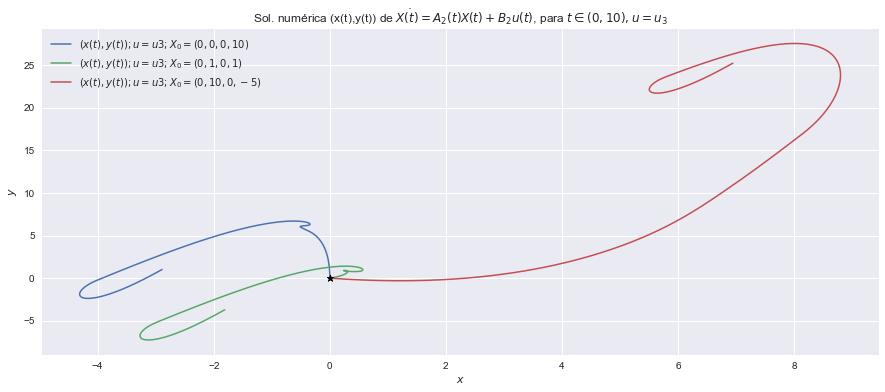

In [203]:
%%time
# bang-bang
SOL_IVP_2_U3=plot_ej_3(A2, B2, u3, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u =u_3$')

**Figura 14**: Trayectorias para sistema con $(a,b,c,d)=(-1,0,4,-1)$, $u$ *bang-bang*, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

CPU times: total: 31.2 ms
Wall time: 42 ms


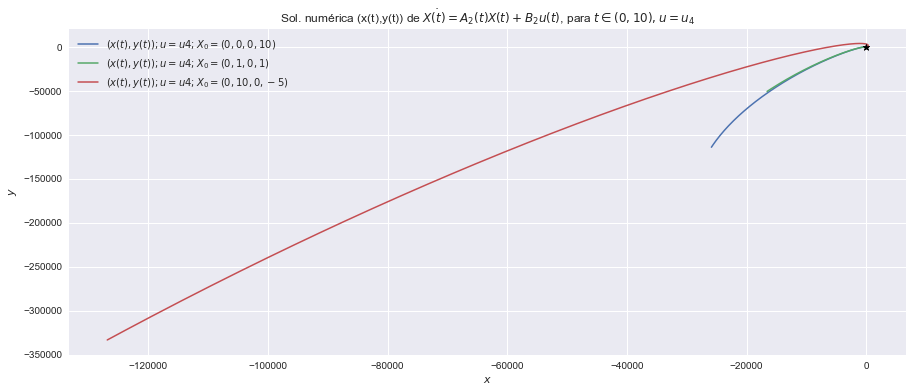

In [43]:
%%time
# feedback
SOL_IVP_2_U4=plot_ej_3(A2, B2, u4, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u =u_4$')

**Figura 15**: Trayectorias para sistema con $(a,b,c,d)=(-1,0,4,-1)$, $u$ *feedback*, $(x_0,y_0)=(0,0)$, $(\dot{x}_0,\dot{y}_0)\in\{(0,10),(1,1),(10,-5)\}$ y $t\in[0,10]$.

Para la segunda configuración del sistema, si $u$ no depende de la posición ni la velocidad vertical, entonces la velocidad horizontal tampoco depende de la posición $y$ del móvil. Luego, para una velocidad inicial en $x$, notando que, con control nulo el objeto desacelera, entonces para $u=(-2,1)$ resulta esperable que la abscisa que describe la ubicación del barco tienda a decrecer indefinidamente, pues se logra compensar la velocidad horizontal positiva al inicio del movimiento y  la aceleración opuesta según la velocidad vertical (la aceleración en $y$ depende cuatro veces la velocidad en $x$, mayor que su porporción de dependencia con respecto a $\dot{y}$).

Para controles sinusoidales, nuevamente se aprecia la reincidencia en estados ya alcanzados. Lo anterior se debe a la periodicidad del control al que se somete la trayectoria del barco. Es razonable que, a partir de cierto instante, el movimiento herede esta característica de $u$.

Para el control *feed-back*, se tiene una aumento considerable en la distancia recorrida para el mismo tiempo utilizado al caso de control nulo, pero en sentido opuesto. Ya no se observa un movimiento elíptico como en el caso anterior, esto puede deberse a que, para el control particular elegido, se pierde la contribución de $\dot{x}$ en la aceleración horizontal, quedando $\ddot{x}=-y+\dot{y}$.

## Ejercicio 4

En el código siguiente, utilizando herramientas de $\texttt{python}$, se calcula la matriz de controlabilidad

$$C = [B, AB, A^2B, \dots , A^{n−1}B],$$

 con $A\in \mathbb{R}^{n\times n}, B\in\mathbb{R}^{n\times p}$ , para los distintos valores de $a$, $b$, $c$ y $d$ dados. Luego, se compara con la matriz obtenida mediante $\texttt{ctrb}$ de $\texttt{control}$. 

In [17]:
def kalman(A, B):
    
    n, m = B.shape

    C = np.zeros([n,n*m])

    C[:,:m]=B

    for i in range(m,n*m,m):
        C[:,i:i+m]=A@C[:,i-m:i]
        
    return C

In [195]:
%%time
print("C para a=-1, b=-2, c=4, d=-5")
C1 = kalman(A1, B1)
pd.DataFrame(C1)

C para a=-1, b=-2, c=4, d=-5
Wall time: 998 µs


,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,-1.0,-2.0,-7.0,12.0
1,1.0,0.0,-1.0,-2.0,-7.0,12.0,55.0,-46.0
2,0.0,0.0,0.0,1.0,4.0,-5.0,-24.0,17.0
3,0.0,1.0,4.0,-5.0,-24.0,17.0,92.0,-37.0


In [194]:
%%time
print("C para a=-1, b=-2, c=4, d=-5 (ctrb)")
C1_ctrb = control.ctrb(A1, B1)
pd.DataFrame(C1_ctrb)

C para a=-1, b=-2, c=4, d=-5 (ctrb)
Wall time: 352 µs


,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,-1.0,-2.0,-7.0,12.0
1,1.0,0.0,-1.0,-2.0,-7.0,12.0,55.0,-46.0
2,0.0,0.0,0.0,1.0,4.0,-5.0,-24.0,17.0
3,0.0,1.0,4.0,-5.0,-24.0,17.0,92.0,-37.0


In [20]:
print("Matrices coinciden: ",np.all(C1 == C1_ctrb))
print("Rango de C:",np.linalg.matrix_rank(C1) )

Matrices coinciden:  True
Rango de C: 4


Para la primera elección de $a,b,c,d$, se verifica que la matriz calculada mediante ambos métodos es la misma. Por otro lado, dado que el conjunto de vectores columna $
\left\{
\begin{pmatrix}
0\\
1\\
0\\
0
\end{pmatrix}
,
\begin{pmatrix}
0\\
0\\
0\\
1\\
\end{pmatrix}
,
\begin{pmatrix}
1\\
-1\\
0\\
4
\end{pmatrix}
,
\begin{pmatrix}
0\\
-2\\
1\\
5
\end{pmatrix}
\right\}$
 es l.i., entonces $C$ es de rango completo ($rango(C)=4$), y, por ende, el sistema $(A_1,B_1)$ es controlable.

In [193]:
%%time
print("C para a=-1, b=0, c=4, d=-1")
C2 = kalman(A2, B2)
pd.DataFrame(C2)

C para a=-1, b=0, c=4, d=-1
Wall time: 370 µs


,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0
1,1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,-1.0,-8.0,1.0
3,0.0,1.0,4.0,-1.0,-8.0,1.0,12.0,-1.0


In [192]:
%%time
print("C para a=-1, b=0, c=4, d=-1 (ctrb)")
C2_ctrb = control.ctrb(A2, B2)
pd.DataFrame(C2_ctrb)

C para a=-1, b=0, c=4, d=-1 (ctrb)
Wall time: 491 µs


,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0
1,1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,-1.0,-8.0,1.0
3,0.0,1.0,4.0,-1.0,-8.0,1.0,12.0,-1.0


In [23]:
print("Matrices coinciden: ", np.all(C2 == C2_ctrb))
print("Rango de C:", np.linalg.matrix_rank(C2) )

Matrices coinciden:  True
Rango de C: 4


Para la segunda selección de $a,b,c,d$, nuevamente la matriz calculada mediante ambos métodos es la misma. Además, dado que el conjunto de vectores columna $
\left\{
\begin{pmatrix}
0\\
1\\
0\\
0
\end{pmatrix}
,
\begin{pmatrix}
0\\
0\\
0\\
1\\
\end{pmatrix}
,
\begin{pmatrix}
1\\
-1\\
0\\
4
\end{pmatrix}
,
\begin{pmatrix}
0\\
0\\
1\\
-1
\end{pmatrix}
\right\}$ es l.i., entonces $C$ es de rango completo, y, en consecuencia, el sistema $(A_2,B_2)$ es controlable.

## Ejercicio 5

A continuación, suponemos que se observa la dinámica del sistema a través del modelo $\vec{Y}=C\vec{X}$, donde $C=
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0
\end{pmatrix}$.

El sistema resultante es de la forma
$$\begin{align*}
\dot{\vec{X}}(t)&=A\vec{X}(t)+B\vec{U}(t)\\
\dot{\vec{Y}}(t)&=C\vec{X}(t)
\end{align*}
$$
Utilizando $\texttt{python}$, se calcula la matriz de observabilidad:

$$\mathcal{O}=[C;CA;C^2A;\dots;C^{n-1}A],$$

In [24]:
C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

In [25]:
def obsv(A, C):
    
    q, n = C.shape

    O = np.zeros([n*q, n])

    O[:q,:]=C

    for i in range(q,n*q,q):
        O[i:i+q,:]=O[i-q:i,:]@A
    return O

In [191]:
%%time
print("O para a=-1, b=-2, c=4, d=-5")
O1 = obsv(A1, C)
pd.DataFrame(O1)

O para a=-1, b=-2, c=4, d=-5
Wall time: 351 µs


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,-1.0,0.0,-2.0
5,0.0,4.0,0.0,-5.0
6,0.0,-7.0,0.0,12.0
7,0.0,-24.0,0.0,17.0


In [190]:
%%time
print("C para a=-1, b=-2, c=4, d=-5 (obsv)")
O1_obsv = control.obsv(A1, C)
pd.DataFrame(O1_obsv)

C para a=-1, b=-2, c=4, d=-5 (obsv)
Wall time: 461 µs


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,-1.0,0.0,-2.0
5,0.0,4.0,0.0,-5.0
6,0.0,-7.0,0.0,12.0
7,0.0,-24.0,0.0,17.0


In [28]:
print("Matrices coinciden: ", np.all(O1 == O1_obsv))
print("Rango de O:", np.linalg.matrix_rank(O1))

Matrices coinciden:  True
Rango de O: 4


In [189]:
%%time
print("O para a=-1, b=0, c=4, d=-1")
O2 = obsv(A2, C)
pd.DataFrame(O2)

O para a=-1, b=0, c=4, d=-1
Wall time: 635 µs


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,-1.0,0.0,0.0
5,0.0,4.0,0.0,-1.0
6,0.0,1.0,0.0,0.0
7,0.0,-8.0,0.0,1.0


In [188]:
%%time
print("O para a=-1, b=0, c=4, d=-1 (obsv)")
O2_obsv = control.obsv(A2, C)
pd.DataFrame(O2_obsv)

O para a=-1, b=0, c=4, d=-1 (obsv)
Wall time: 0 ns


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,-1.0,0.0,0.0
5,0.0,4.0,0.0,-1.0
6,0.0,1.0,0.0,0.0
7,0.0,-8.0,0.0,1.0


In [31]:
print("Matrices coinciden: ", np.all(O2 == O2_obsv))
print("Rango de O:", np.linalg.matrix_rank(O2) )

Matrices coinciden:  True
Rango de O: 4


Tanto para la primera como para la segunda elección de $a$, $b$, $c$ y $d$, se obtiene que la matriz de observabilidad calculada coincide para los dos métodos empleados. Además, ambas matrices poseen en su colección de vectores fila a la familia de vectores canónicos de $\mathbb{R}^4$ ($\{e_i\}_{i=1}^4$), por lo que son de rango completo. Así, $(A_1,B_1,C)$ y $(A_2,B_2,C)$ son sistemas observables.

## Ejercicio 6

En los siguientes bloques se definen los espacios de estado de los sistemas de observabilidad, y se ejecuta la función $\texttt{gram}$ sobre ellos para obtener su Gramiano.

In [32]:
#state space
ss1 = control.StateSpace(A1, B1, C, np.zeros((C.shape[0], B1.shape[1])))
ss1

StateSpace(array([[ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0., -2.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  4.,  0., -5.]]), array([[0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0., 0.],
       [0., 0.]]))

In [33]:
#state space
ss2 = control.StateSpace(A2, B2, C, np.zeros((C.shape[0], B2.shape[1])))
ss2

StateSpace(array([[ 0.,  1.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  4.,  0., -1.]]), array([[0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0., 0.],
       [0., 0.]]))

In [34]:
control.gram(ss1, "c")

ValueError: Oops, the system is unstable!

In [35]:
control.gram(ss2, "c")

ValueError: Oops, the system is unstable!

In [36]:
control.gram(ss1, "o")

ValueError: Oops, the system is unstable!

In [37]:
control.gram(ss2, "o")

ValueError: Oops, the system is unstable!

No es posible calcular los Gramianos del sistema, dado que la matriz $A$ tiene valores propios con parte real negativa.

# Parte C

## Ejercicio 7

Considerando $U = −KX$ para una matriz K apropiada, el sistema (2) se puede escribir como sigue
$$
\dot{X}= (A − BK)X.
$$
Utilice el comando $\texttt{place}$ para obtener una matriz de ganancia $K$ tal que $A − BK$ sea asintóticamente estable, luego utilice el comando $\texttt{lqr}$ para obtener una matriz de ganancia $K$ tal que $A−BK$ sea estable y verifique usando el comando $\texttt{eig}$ que la matriz $A − BK$ es asintóticamente estable. Compare los resultados obtenidos al utilizar ambos comandos. Simule las trayectorias obtenidas por estos controles para distintas condiciones iniciales, y comente los resultados encontrados.

In [186]:
K1place = control.place(A1, B1, -np.array([1, 1/2, 1/3, 1/4]))
print("K:")
pd.DataFrame(K1place)

K:


,0,1,2,3
0,0.276992,0.175576,-0.092539,-2.259108
1,-0.092540,3.740889,0.181342,-4.092243


In [187]:
print("eigvalues: A-BK")
pd.DataFrame(np.linalg.eig(A1-B1@K1place)[0])

eigvalues: A-BK


,0
0,-1.000000
1,-0.500000
2,-0.333333
3,-0.250000


In [184]:
K2place = control.place(A2, B2, -np.array([1, 1/2, 1/3, 1/4]))
print("K:")
pd.DataFrame(K2place)

K:


,0,1,2,3
0,0.276992,0.175576,-0.092539,-0.259108
1,-0.092540,3.740889,0.181342,-0.092243


In [185]:
print("eigvalues: A-BK")
pd.DataFrame(np.linalg.eig(A2-B2@K2place)[0])

eigvalues: A-BK


,0
0,-1.000000
1,-0.500000
2,-0.333333
3,-0.250000


In [182]:
K_1 = control.lqr(A1, B1, np.eye(4), np.eye(2))
K1lqr = K_1[0]
print("K:")
pd.DataFrame(K1lqr)

K:


,0,1,2,3
0,0.759818,0.744104,0.650136,-0.059278
1,-0.650136,-0.059278,0.759818,0.268134


In [183]:
print("eigvalues: A-BK")
pd.DataFrame(np.linalg.eig(A1-B1@K1lqr)[0])

eigvalues: A-BK


,0
0,-3.206579+2.096058j
1,-3.206579-2.096058j
2,-0.152626+0.000000j
3,-0.446453+0.000000j


In [180]:
K_2 = control.lqr(A2, B2, np.eye(4), np.eye(2))
K2lqr = K_2[0]
print("K:")
pd.DataFrame(K2lqr)

K:


,0,1,2,3
0,0.757442,1.883023,0.652902,0.652902
1,-0.652902,0.652902,0.757442,0.757442


In [181]:
print("eigvalues: A-BK")
pd.DataFrame(np.linalg.eig(A2-B2@K2lqr)[0])

eigvalues: A-BK


,0
0,-1.705050+1.197384j
1,-1.705050-1.197384j
2,-0.230366+0.000000j
3,-1.000000+0.000000j


In [42]:
def u1place(x, t):
    return - K1place @ x
def u2place(x, t):
    return - K2place @ x
def u1lqr(x, t):
    return - K1lqr @ x
def u2lqr(x, t):
    return - K1lqr @ x

Wall time: 42.9 ms


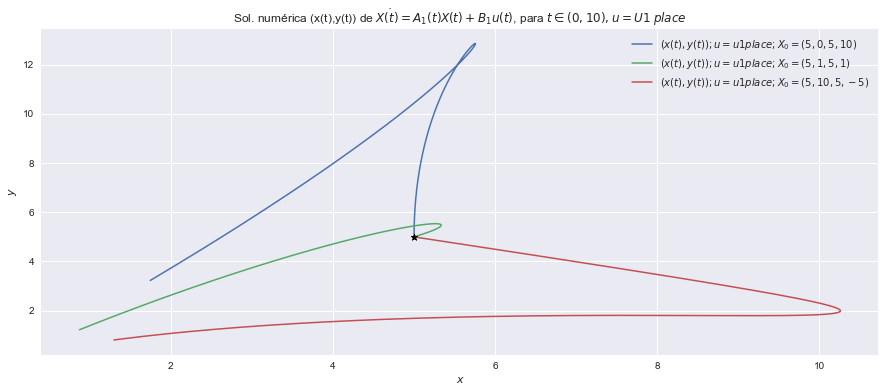

In [107]:
%%time
# feedbacks -K @ x
SOL_IVP_1_U1PLACE = plot_ej_3(A1, B1, u1place, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u=U1_ place$')

Wall time: 49.9 ms


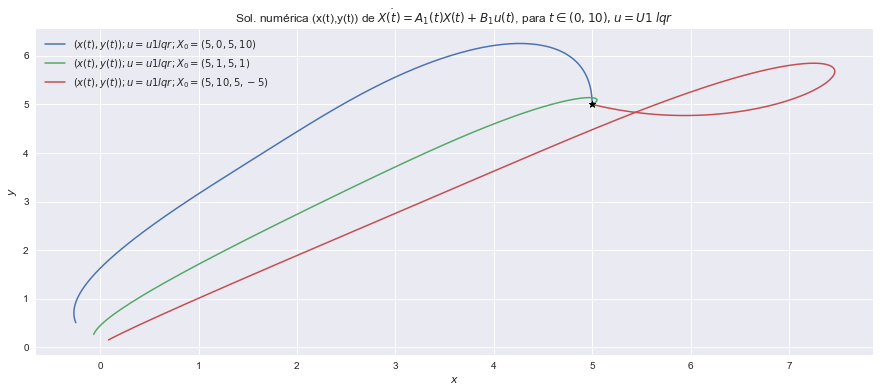

In [108]:
%%time
# feedbacks -K @ x
SOL_IVP_1_U1LQR = plot_ej_3(A1, B1, u1lqr, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_1(t)X(t)+B_1u(t)$, para $t\in' +str(t_span)+', u=U1_ lqr$')

Wall time: 43.9 ms


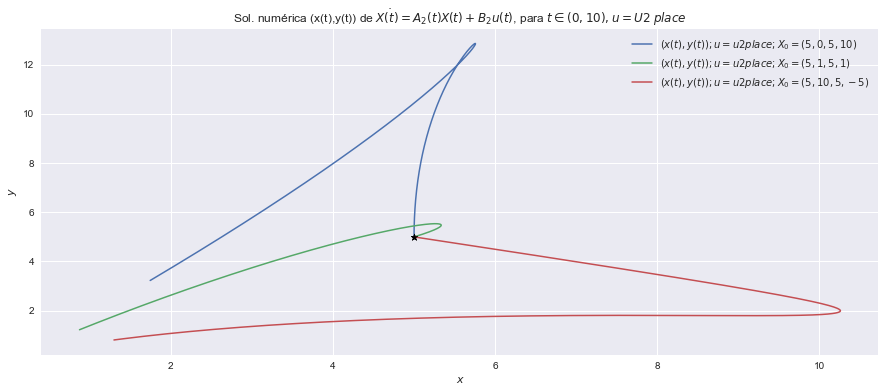

In [109]:
%%time
# feedbacks -K @ x
SOL_IVP_2_U2PLACE = plot_ej_3(A2, B2, u2place, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u=U2_ place$')

Wall time: 47.9 ms


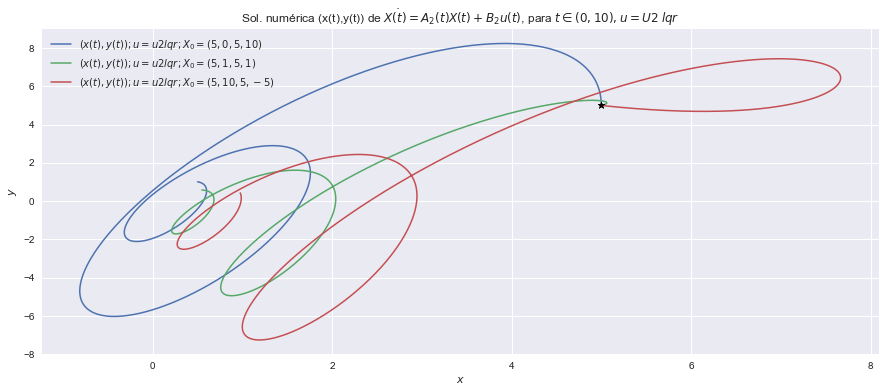

In [110]:
%%time
# feedbacks -K @ x
SOL_IVP_2_U2LQR = plot_ej_3(A2, B2, u2lqr, X_0, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{X(t)}=A_2(t)X(t)+B_2u(t)$, para $t\in' +str(t_span)+', u=U2_ lqr$')

## Ejercicio 8

Usualmente es difícil conocer completamente las variables de estado ya que sólo podemos
obtener observaciones imprecisas de estas. Por ejemplo, si estamos controlando nuestro barco desde
Chile, vía satélite, no podemos saber siempre su velocidad exacta y sólo podemos estimarla, por ejemplo, usando dispositivos GPS. Por esto, en lo que sigue, supondremos que solamente observamos la posición del barco $(x1, x3)$ pero no su velocidad. Esto nos lleva a considerar un observador de la forma:
$$
Y = CX
$$

* Identifique $C$ e $Y$:

$$
C = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 0&  1 & 0\end{bmatrix}
$$
$$
Y = \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 0&  1 & 0\end{bmatrix} \begin{bmatrix} x \\ dx \\y  \\ dy\end{bmatrix} = C X
$$

* Definamos el estimador $\hat{X}$ como la solución del siguiente sistema:

$$
\dot{\hat{X}}(t) = A \hat{X}(t) + BU(t) + L(Y(t) − C\hat{X}(t)), 
$$
donde el estado inicial $\hat{X}(0) = \hat{X}_0$ es conocido y dado por usted y la matriz $L$ representa la ganancia de la diferencia entre la observación y la estimación del estado. Utilizando los comandos del Ejercicios 8, encuentre matrices $L$ tales que el estimador $\hat{X}$ converja asintóticamente a $X$ , o en otras palabras, que el error de estimación $e(t) := X(t) −
\hat{X}(t)$ converja a cero cuando $t\rightarrow +\infty$.

In [169]:
L1place = control.place(A1.T, C.T, -np.array([1, 1/2, 1/3, 1/4]))
L1place = L1place.T
pd.DataFrame(L1place)

,0,1
0,-0.038612,-2.091877
1,-6.048850,9.814944
2,3.144244,-3.878055
3,-16.180083,11.280071


In [170]:
L2place = control.place(A2.T, C.T, -np.array([1, 1/2, 1/3, 1/4]))
L2place = L2place.T
pd.DataFrame(L2place)

,0,1
0,0.122158,-0.068716
1,0.136613,0.044098
2,2.856778,-0.038825
3,-2.772964,-0.036511


In [171]:
L1lqr = control.lqr(A1.T, C.T, np.eye(4), np.eye(2))
L1lqr = L1lqr[0].T
pd.DataFrame(L1lqr)

,0,1
0,1.065348,0.037202
1,0.068175,0.014714
2,0.037202,1.039513
3,0.063590,0.040986


In [172]:
L2lqr = control.lqr(A2.T, C.T, np.eye(4), np.eye(2))
L2lqr = L2lqr[0].T
pd.DataFrame(L2lqr)

,0,1
0,1.139614,0.261207
1,0.183475,0.238228
2,0.261207,1.817928
3,0.534302,1.186546


* Simule el estimador obtenido para los controles utilizados en el Ejercicio 3 y 7 con las respectivas condiciones iniciales.

In [51]:
def estimator(t, x, A, B, C, L, u, x_org):
    dx = A @ x + B @ u(x, t) + L @ ( C @ x_org.sol(t) - C @ x )
    return dx

In [52]:
def solve_estimator_u(A, B, C, L, u, x_org, x_0=np.array([0,0,1,1]),t_span=(0.0,10.0)):
    
    sol_ivp = solve_ivp(estimator, t_span, x_0, args=[A, B, C, L, u, x_org], dense_output=True)
    
    return sol_ivp

In [118]:
def plot_ej_8(A, B, C, L, u, X_org, X_0, t_span, title):
    
    SOL_IVP = [solve_estimator_u(A, B, C, L, u, X_org[i], x_0, t_span) for i, x_0 in enumerate(X_0)]
    T = np.arange(t_span[0], t_span[1], 0.01)
    
    fig, ax = plt.subplots(1,1, figsize=(15,6),sharey=True, sharex=True) 
    
    ax.set_title(title)
    ax.set_xlabel(r'$x$')  
    ax.set_ylabel(r'$y$')
    ax.grid(zorder=-1)
    
    for i in range(3):
        # ESTIMADOR
        x_0=X_0[i]
        X_, Y_ = SOL_IVP[i].sol(T)[0], SOL_IVP[i].sol(T)[2]
        __ = ax.plot(X_,Y_, label=r'$(x(t),y(t)); u='+str(u.__name__)+'; X_0='+str((x_0[0],x_0[1],x_0[2],x_0[3]))+'$', linewidth=1.5)
        ax.scatter([x_0[0]],[x_0[2]],zorder=2,color='black',marker='*')
        color_i = __[0].get_color()
        # ORIGINAL
        x_org_0 = X_org[i].y[:, 0]
        X_org_, Y_org_ = X_org[i].sol(T)[0], X_org[i].sol(T)[2]
        ax.plot(X_org_, Y_org_, linestyle="-.", color=color_i, label=r'$(x(t),y(t)); u='+str(u.__name__)+'; X_0='+str((x_org_0[0],x_org_0[1],x_org_0[2],x_org_0[3]))+'$', linewidth=1.5)
        ax.scatter([x_org_0[0]],[x_org_0[2]],zorder=2,color='black',marker='*')
        
    ax.legend()
    return SOL_IVP

In [115]:
X_0_hat = [np.array([0, 10, 0, 10]) for x_0 in X_0]

Wall time: 70.8 ms


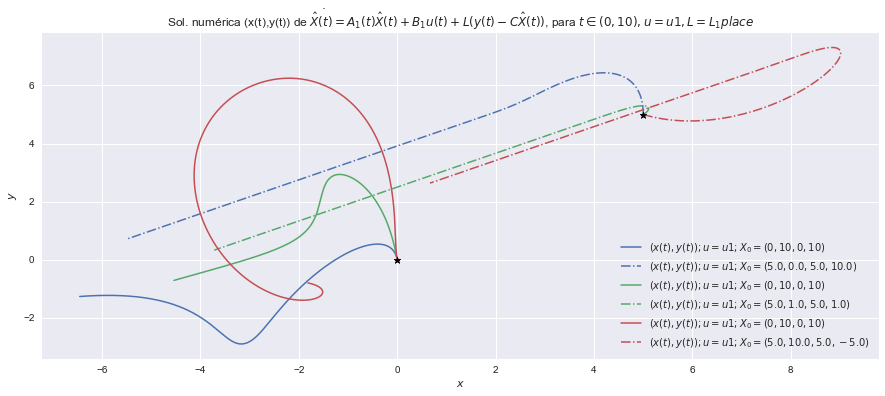

In [126]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u1, SOL_IVP_1_U1, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u1, L=L_1 place$'); # Constante

Wall time: 82.8 ms


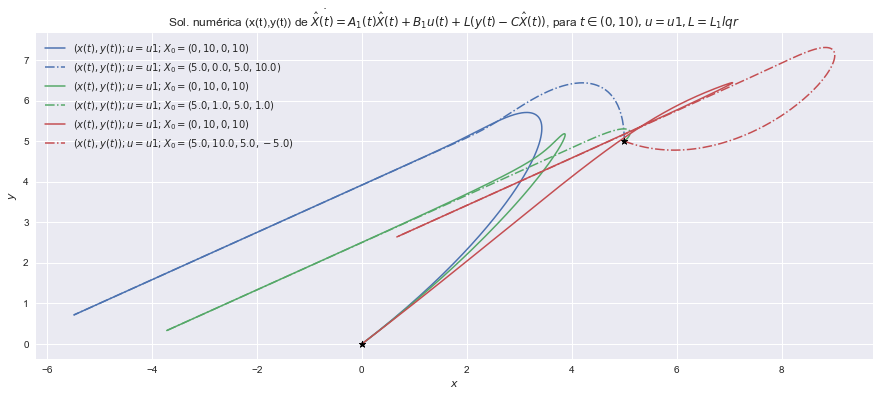

In [127]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u1, SOL_IVP_1_U1, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u1, L=L_1 lqr$'); # Constante

Wall time: 85.8 ms


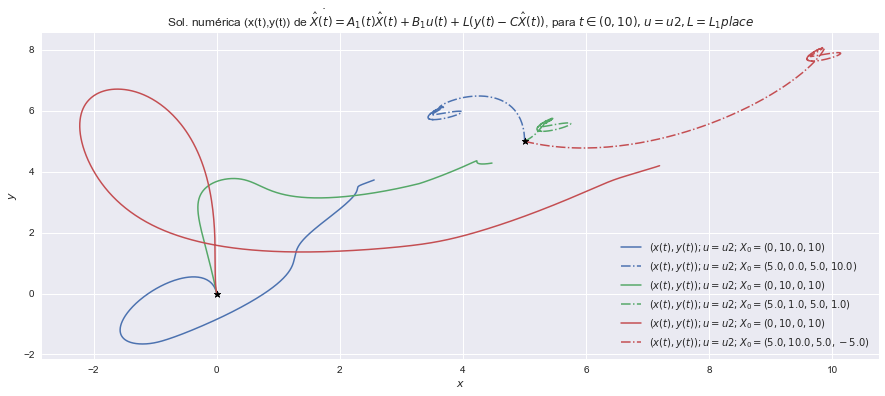

In [128]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u2, SOL_IVP_1_U2, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u2, L=L_1 place$'); # Sinusoidal

Wall time: 121 ms


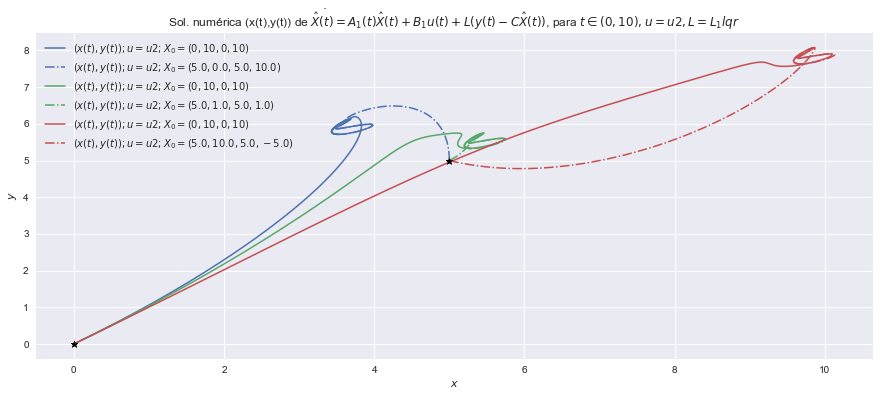

In [129]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u2, SOL_IVP_1_U2, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u2, L=L_1 lqr$'); # Sinusoidal

Wall time: 105 ms


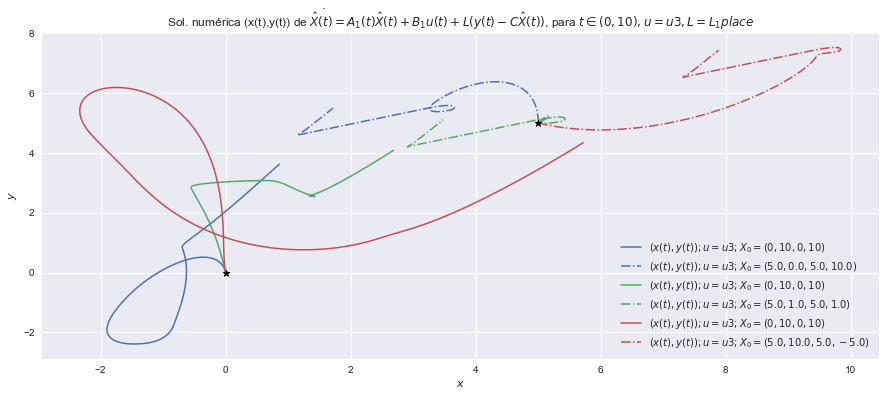

In [130]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u3, SOL_IVP_1_U3, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u3, L=L_1 place$'); # bang-bang

Wall time: 136 ms


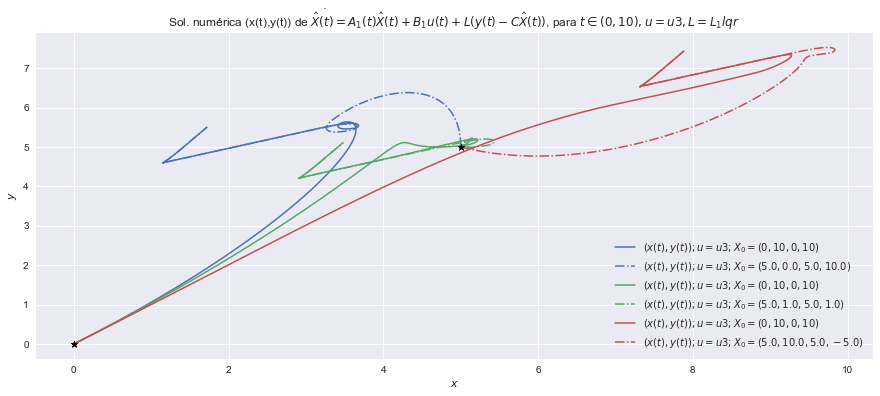

In [131]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u3, SOL_IVP_1_U3, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u3, L=L_1 lqr$'); # bang-bang

Wall time: 97.7 ms


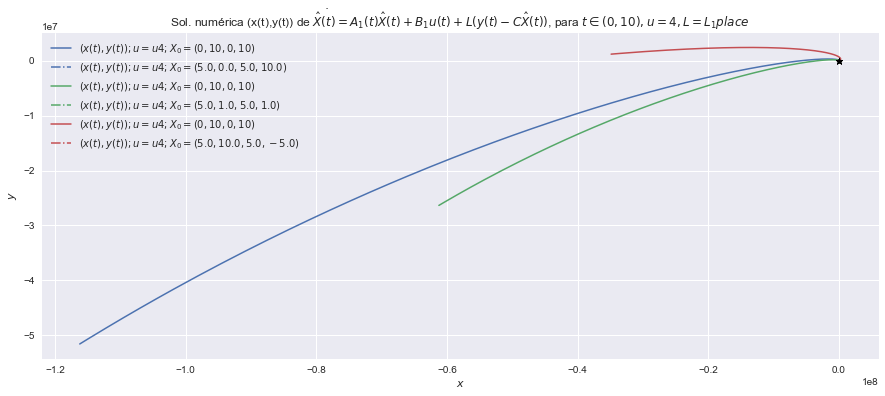

In [132]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u4, SOL_IVP_1_U4, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=4, L=L_1 place$'); # feedbacks

Wall time: 99.7 ms


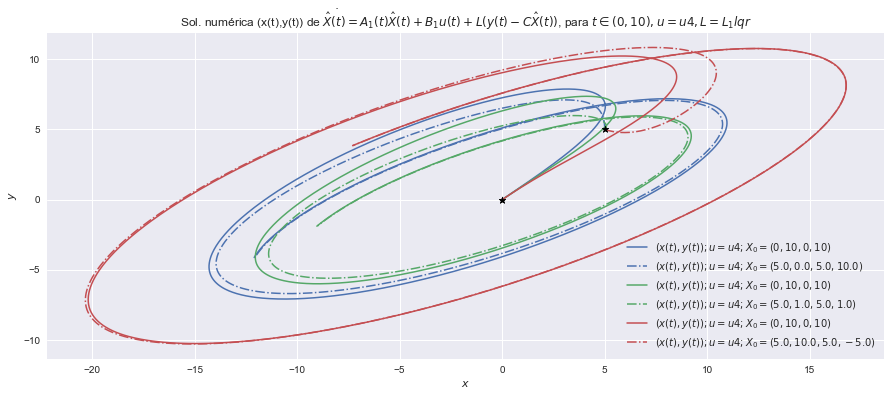

In [133]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u4, SOL_IVP_1_U4, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u4, L=L_1 lqr$'); # -K x place

Wall time: 93.8 ms


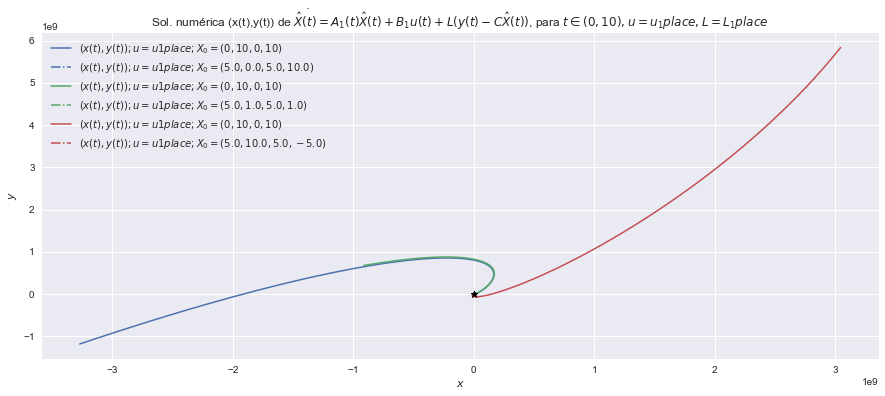

In [134]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u1place, SOL_IVP_1_U1PLACE, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_1 place, L=L_1 place$'); # -K x place

Wall time: 74.8 ms


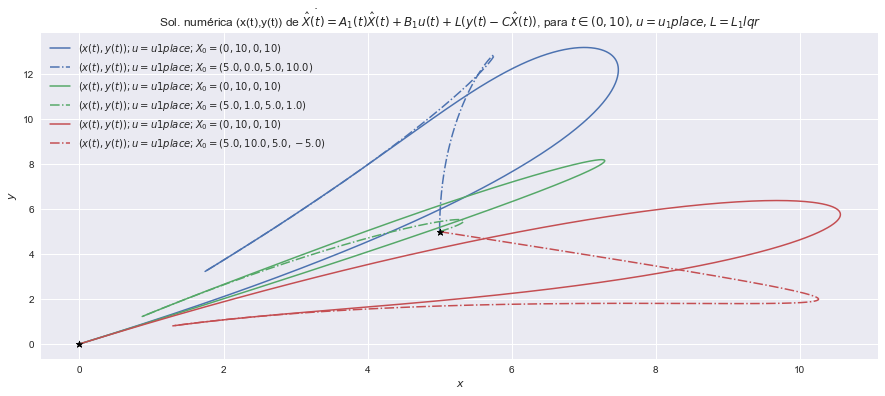

In [135]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u1place, SOL_IVP_1_U1PLACE, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_1 place, L=L_1 lqr$'); # -K x lqr

Wall time: 78.8 ms


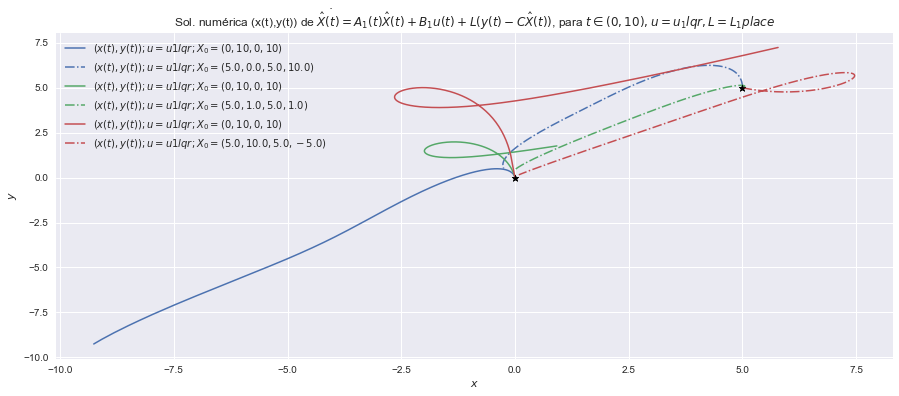

In [136]:
%%time
_ = plot_ej_8(A1, B1, C, L1place, u1lqr, SOL_IVP_1_U1LQR, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_1 lqr, L=L_1 place$'); # -K x lqr

Wall time: 92.8 ms


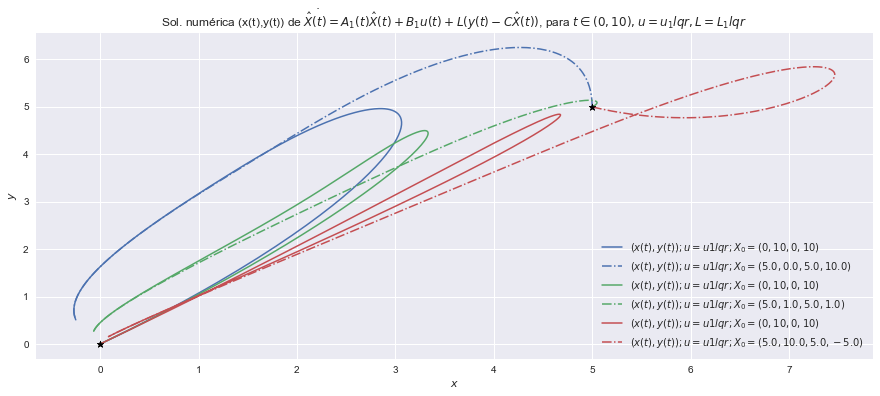

In [137]:
%%time
_ = plot_ej_8(A1, B1, C, L1lqr, u1lqr, SOL_IVP_1_U1LQR, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_1(t)\hat{X}(t)+B_1u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_1 lqr, L=L_1 lqr$'); # -K x lqr

Wall time: 69.8 ms


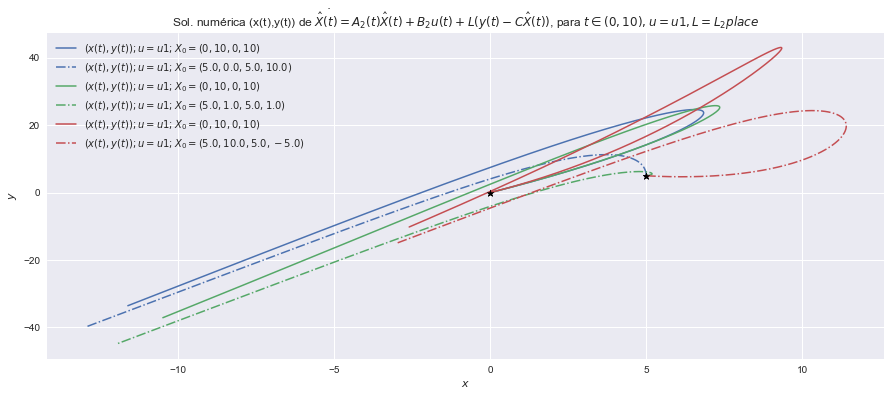

In [141]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u1, SOL_IVP_2_U1, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u1, L=L_2 place$'); # Constante

Wall time: 135 ms


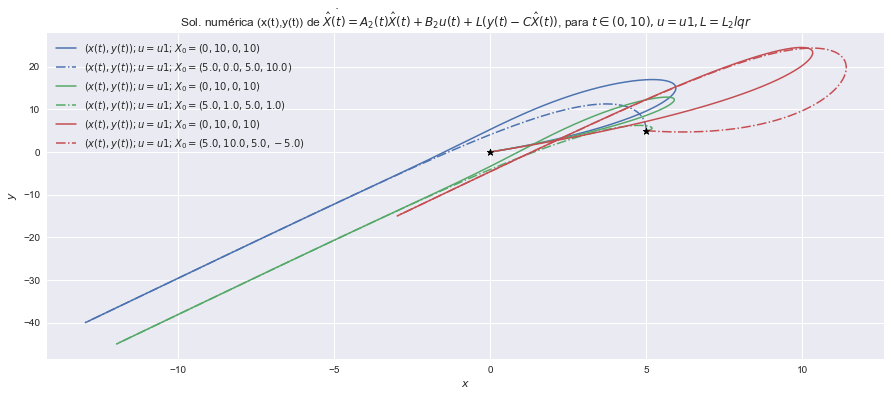

In [142]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u1, SOL_IVP_2_U1, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u1, L=L_2 lqr$'); # Constante

Wall time: 80.8 ms


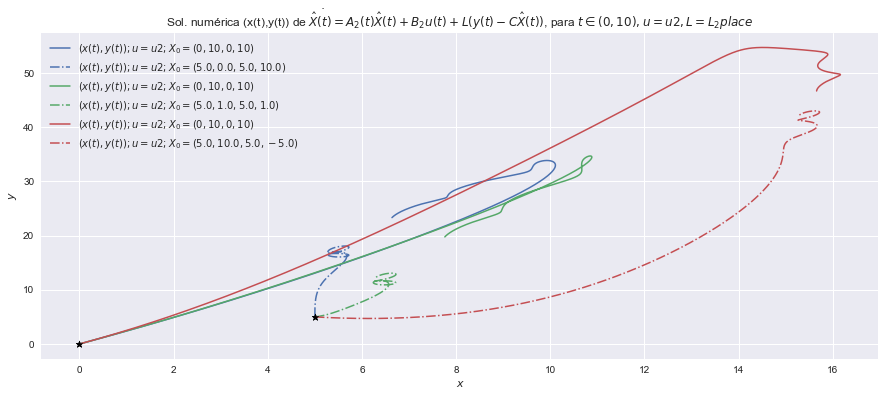

In [143]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u2, SOL_IVP_2_U2, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u2, L=L_2 place$'); # Sinusoidal

Wall time: 95.8 ms


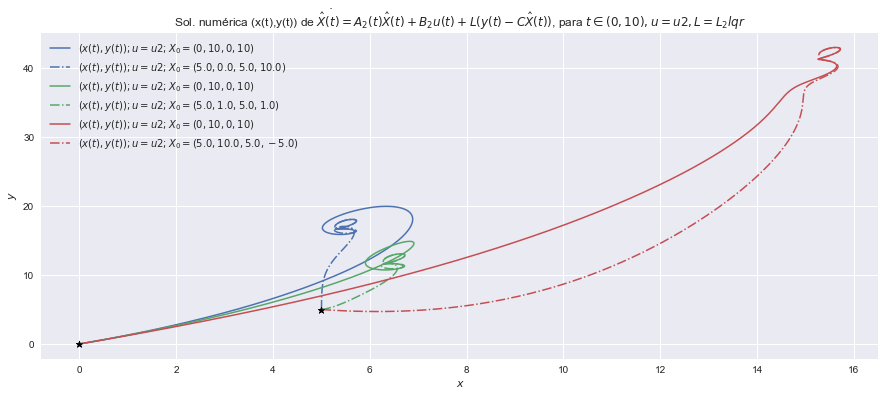

In [144]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u2, SOL_IVP_2_U2, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u2, L=L_2 lqr$'); # Sinusoidal

Wall time: 89.8 ms


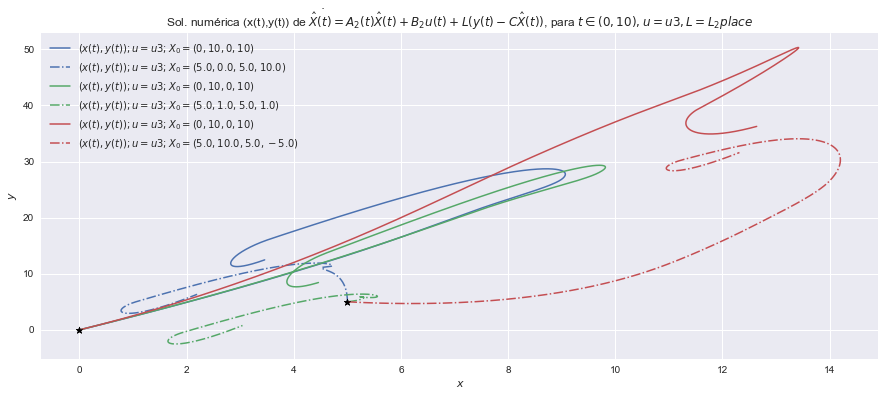

In [145]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u3, SOL_IVP_2_U3, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u3, L=L_2 place$'); # bang-bang

Wall time: 128 ms


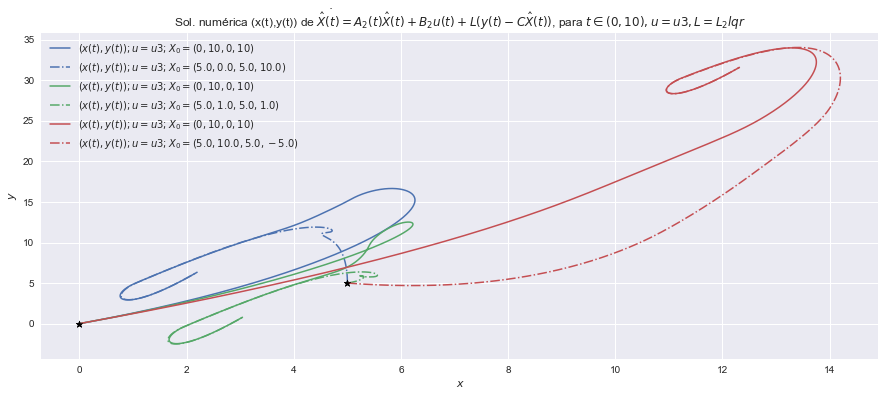

In [146]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u3, SOL_IVP_2_U3, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u3, L=L_2 lqr$'); # bang-bang

Wall time: 76.8 ms


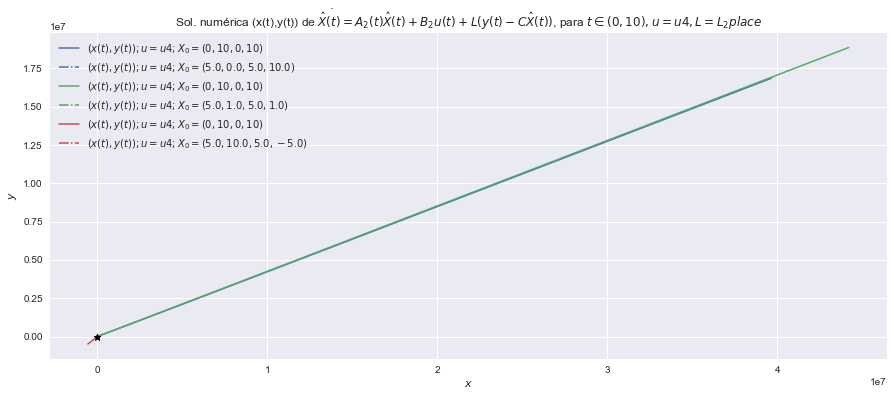

In [147]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u4, SOL_IVP_2_U4, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u4, L=L_2 place$'); # feedbacks

Wall time: 84.8 ms


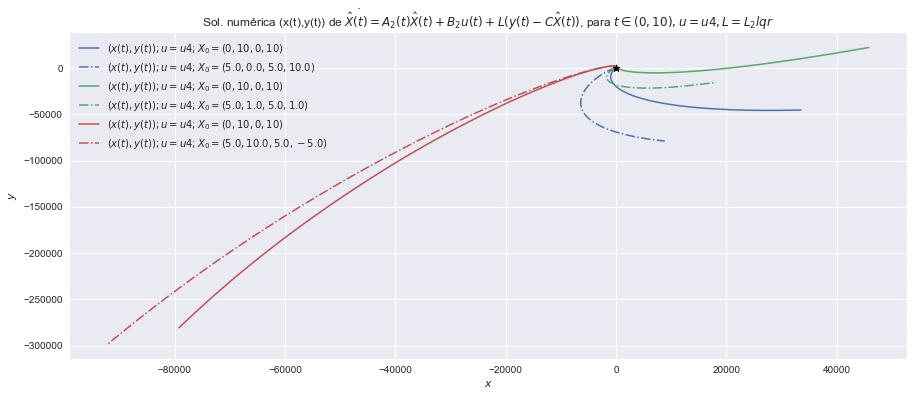

In [148]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u4, SOL_IVP_2_U4, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u4, L=L_2 lqr$'); # -K x place

Wall time: 74.8 ms


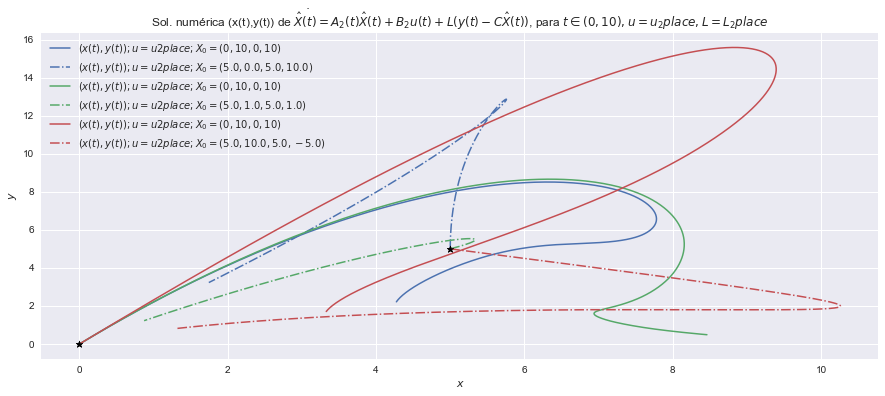

In [149]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u2place, SOL_IVP_2_U2PLACE, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_2 place, L=L_2 place$'); # -K x place

Wall time: 84.8 ms


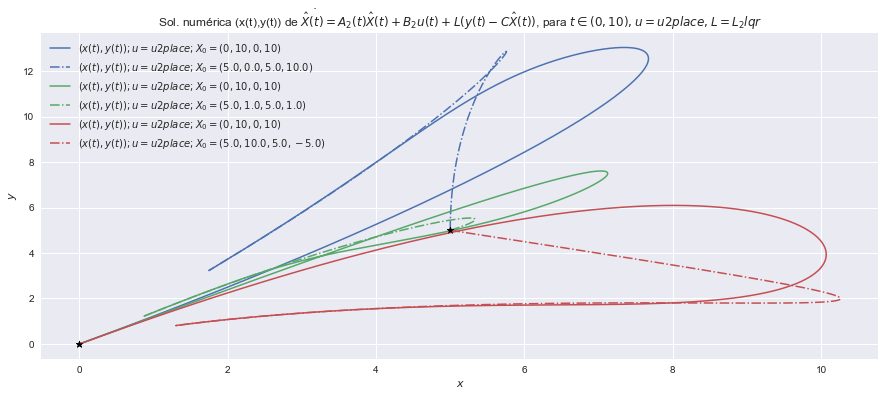

In [150]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u2place, SOL_IVP_2_U2PLACE, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u2 place, L=L_2 lqr$'); # -K x lqr

Wall time: 109 ms


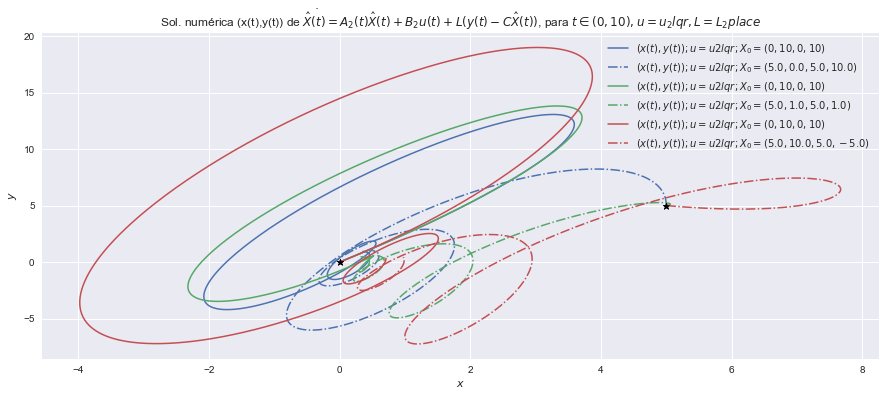

In [151]:
%%time
_ = plot_ej_8(A2, B2, C, L2place, u2lqr, SOL_IVP_2_U2LQR, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_2 lqr, L=L_2 place$'); # -K x lqr

Wall time: 96.8 ms


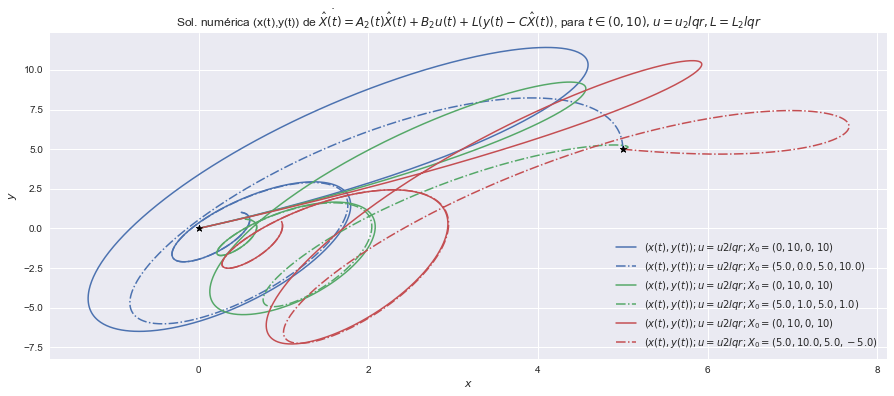

In [152]:
%%time
_ = plot_ej_8(A2, B2, C, L2lqr, u2lqr, SOL_IVP_2_U2LQR, X_0_hat, t_span, r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=A_2(t)\hat{X}(t)+B_2u(t)+L(y(t) - C\hat{X}(t))$, para $t\in' +str(t_span)+', u=u_2 lqr, L=L_2 lqr$'); # -K x lqr

## Ejercicio 9

Utilizando un control regulador feedback lineal, asumiendo que usted sólo tiene acceso al
estimador de $\hat{X}$, y suponiendo que $Y = CX$, deduzca de las ecuaciones (6) y $\dot{e}(t) = (A − LC)e(t)$, un sistema de la forma:
$$
\begin{bmatrix} \hat{X} \\ e \end{bmatrix}' = \hat{A}(A, B, C, K, L) \begin{bmatrix} \hat{X} \\ e \end{bmatrix}
$$
encuentre matrices $K$ y $L$ que hagan estables a la matrices $A − BK$ y $A − LC$ y por lo tanto a la matriz $\hat{A}(B, C, K, L)$ (¿Por qué?). Finalmente simule lo obtenido.

En lo que sigue encontraremos explicitamente la metriz $\hat{A}$ y con esto mostraremos porque si las matrices $A-BK$ y $A-LC$ son estables entonces $\hat{A}$ tambien lo es.

En efecto, si consideramos un feedbak lineal $U(t) =  -K X(t)$, recordando que las observacion viene dada por $Y(t) = CX(t)$ y que el error es de la forma $e(t)=X(t) - \hat{X}(t)$deducimos de la dinamica del estimador $\hat{X}$ que:
\begin{align*}
\dot{\hat{X}}(t) &= A \hat{X}(t) + BU(t) + L(Y(t) − C\hat{X}(t))\\
&= A \hat{X}(t) - BKX(t) + L(CX(t) − C\hat{X}(t))\\
&= A \hat{X}(t) - BKX(t) + LCe(t)\\
&= A \hat{X}(t) - BKX(t) +BK\hat{X}(t)-BK\hat{X}(t)+ LCe(t)\\
&= (A -BK)\hat{X}(t) - BK(X(t) -hat{X})+ LCe(t)\\
&= (A -BK)\hat{X}(t) - BKe(t)+ LCe(t)\\
&= (A -BK)\hat{X}(t) + (LC- BK)e(t)\\
\end{align*}
Entonces tenemos el siguiente sistema:

\begin{align*}
\dot{\hat{X}}(t) &=  (A -BK)\hat{X}(t) + (LC- BK)e(t)\\
\dot{e}(t) &= 0 \cdot \hat{X}(t) + (A − LC)e(t)\\
\end{align*}
es decir:
$$
\begin{bmatrix} \hat{X} \\ e \end{bmatrix}' = \begin{bmatrix} A -BK & LC- BK \\ 0 & A − LC \end{bmatrix} \begin{bmatrix} \hat{X} \\ e \end{bmatrix}.
$$
Para concluir, la matriz $\hat{A}$ es estable ya que 
$$
det(\hat{A}) = det(A-BK)\cdot det(A-LC)
$$
entonces $ $

* Simule lo obtenido:

In [173]:
K1lqr = K_1[0]
AA1 = np.block([[A1 - B1 @ K1lqr, L1lqr @ C - B1 @ K1lqr], [np.zeros(A1.shape), A1 - L1lqr @ C]])
pd.DataFrame(AA1)

,0,1,2,3,4,5,6,7
0,0.000000,1.000000,0.000000,0.000000,1.065348,0.000000,0.037202,0.000000
1,-0.759818,-1.744104,-0.650136,-1.940722,-0.691643,-0.744104,-0.635422,0.059278
2,0.000000,0.000000,0.000000,1.000000,0.037202,0.000000,1.039513,0.000000
3,0.650136,4.059278,-0.759818,-5.268134,0.713726,0.059278,-0.718832,-0.268134
4,0.000000,0.000000,0.000000,0.000000,-1.065348,1.000000,-0.037202,0.000000
5,0.000000,0.000000,0.000000,0.000000,-0.068175,-1.000000,-0.014714,-2.000000
6,0.000000,0.000000,0.000000,0.000000,-0.037202,0.000000,-1.039513,1.000000
7,0.000000,0.000000,0.000000,0.000000,-0.063590,4.000000,-0.040986,-5.000000


In [174]:
K2lqr = K_2[0]
AA2 = np.block([[A2 - B2 @ K2lqr, L2lqr @ C - B2 @ K2lqr], [np.zeros(A2.shape), A2 - L2lqr @ C]])
pd.DataFrame(AA2)

,0,1,2,3,4,5,6,7
0,0.000000,1.000000,0.000000,0.000000,1.139614,0.000000,0.261207,0.000000
1,-0.757442,-2.883023,-0.652902,-0.652902,-0.573967,-1.883023,-0.414674,-0.652902
2,0.000000,0.000000,0.000000,1.000000,0.261207,0.000000,1.817928,0.000000
3,0.652902,3.347098,-0.757442,-1.757442,1.187204,-0.652902,0.429104,-0.757442
4,0.000000,0.000000,0.000000,0.000000,-1.139614,1.000000,-0.261207,0.000000
5,0.000000,0.000000,0.000000,0.000000,-0.183475,-1.000000,-0.238228,0.000000
6,0.000000,0.000000,0.000000,0.000000,-0.261207,0.000000,-1.817928,1.000000
7,0.000000,0.000000,0.000000,0.000000,-0.534302,4.000000,-1.186546,-1.000000


In [84]:
def error(t, x, AA):
    dx = AA @ x
    return dx

In [85]:
def solve_error(AA, x_0=np.array([0, 0, 1, 1, 10, 5, 10, 5]), t_span=(0.0, 10.0)):
    
    sol_ivp = solve_ivp(error, t_span, x_0, args=[AA], dense_output=True)
    
    return sol_ivp

In [160]:
def plot_ej_9(AA, X_0, t_span, title):
    
    SOL_IVP = [solve_error(AA, x_0, t_span) for x_0 in X_0]
    T = np.arange(t_span[0], t_span[1], 0.01)
    
    fig, ax = plt.subplots(2,1, figsize=(15,6*2),sharey=True, sharex=True) 
    
    ax[0].set_title(title)
    ax[0].set_xlabel(r'$x$')  
    ax[0].set_ylabel(r'$y$')
    ax[0].grid(zorder=-1)
    
    ax[1].set_title("Error")
    ax[1].set_xlabel(r'Error en $x$')  
    ax[1].set_ylabel(r'Error en $y$')
    for i in range(3):
        x_0=X_0[i]
        
        # ERROR
        eX_, eY_ = SOL_IVP[i].sol(T)[4], SOL_IVP[i].sol(T)[6]
        __ = ax[1].plot(eX_,eY_, label=r'$(x(t),y(t)); e_0='+str((x_0[4],x_0[5],x_0[6],x_0[7]))+'$', linewidth=1.5)
        ax[1].scatter([x_0[4]],[x_0[6]],zorder=2,color='black',marker='*')
        color_i = __[0].get_color()
        
        # ESTIMADOR
        X_, Y_ = SOL_IVP[i].sol(T)[0], SOL_IVP[i].sol(T)[2]
        ax[0].plot(X_, Y_, linestyle="-.", color=color_i, label=r'$(x(t),y(t)); X_0='+str((x_0[0],x_0[1],x_0[2],x_0[3]))+'$', linewidth=1.5)
        ax[0].scatter([x_0[0]],[x_0[2]],zorder=2,color='black',marker='*')
        
        # ORIGINAL
        X_org_, Y_org_ = SOL_IVP[i].sol(T)[0]-SOL_IVP[i].sol(T)[4], SOL_IVP[i].sol(T)[2]-SOL_IVP[i].sol(T)[6]
        ax[0].plot(X_org_, Y_org_, color=color_i, label=r'$(x(t),y(t)); X_0='+str((x_0[0]-x_0[4],x_0[1]-x_0[5],x_0[2]-x_0[6],x_0[3]-x_0[7]))+'$', linewidth=1.5)
        ax[0].scatter([x_0[0]-x_0[4]],[x_0[2]-x_0[6]],zorder=2,color='black',marker='*')
        
    ax[0].legend()
    ax[1].legend()
    return SOL_IVP

In [161]:
X_0_e_0 = [np.array([5,0,5,10,10,-5,10,5]),np.array([15,0,15,10,20,-5,20,5]),np.array([0,0,0,10,5,-5,5,5])]

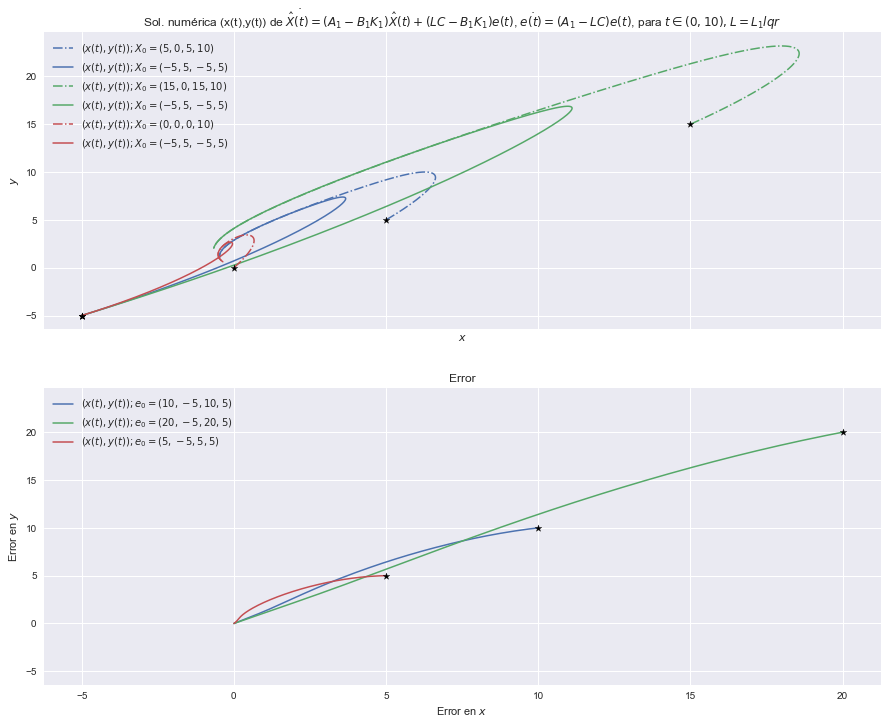

In [165]:
_ = plot_ej_9(AA1,X_0_e_0,t_span,r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=(A_1-B_1 K_1)\hat{X}(t) + (LC-B_1 K_1)e(t)$, $\dot{e(t)} = (A_1- LC) e(t)$, para $t\in' +str(t_span)+', L=L_1 lqr$');

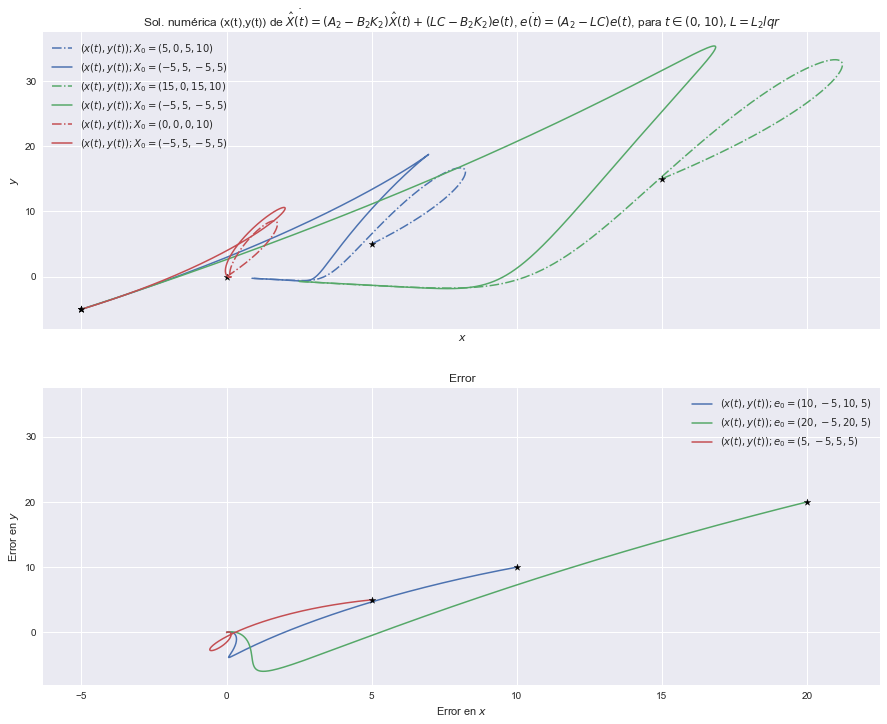

In [166]:
_ = plot_ej_9(AA2,X_0_e_0,t_span,r'Sol. numérica (x(t),y(t)) de $\dot{\hat{X}(t)}=(A_2-B_2 K_2)\hat{X}(t) + (LC-B_2 K_2)e(t)$, $\dot{e(t)} = (A_2- LC) e(t)$, para $t\in' +str(t_span)+', L=L_2 lqr$');